In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict
import spacy
import string
from wordcloud import WordCloud, STOPWORDS

In [2]:
# !pip install spacy

In [3]:
# !pip install wordcloud

## Loading Train and test data

In [4]:
train_data_log= pd.read_csv('./SAMPLE_DATA/labeled-encoded-data-samples/may_jun_jul_2021.csv')


### Read Train 

In [5]:
train_data_log.head()

,length,params_number,return_code,size,upper_cases,lower_cases,special_chars,url_depth,label,log_line
0,98,1,301,606,10,67,7,9,0,23.228.109.147 - - [01/May/2021:02:39:43 -0700...
1,98,1,404,291,10,67,7,9,0,23.228.109.147 - - [01/May/2021:02:39:43 -0700...
2,48,1,200,24768,7,19,7,3,0,207.46.13.53 - - [01/May/2021:02:44:34 -0700] ...
3,52,1,200,847,7,18,7,4,0,114.119.141.53 - - [01/May/2021:02:46:43 -0700...
4,14,1,200,12844,7,0,1,2,0,106.38.241.178 - - [01/May/2021:02:47:47 -0700...


The given text is an example of a log entry in the Common Log Format (CLF) typically found in web server logs. 

1. **IP Address**: "23.228.109.147" - This is the IP address of the client that made the request to the server.
2. **Date and Time**: "[01/May/2021:02:39:43 -0700]" - This is the timestamp indicating when the request was made. In this example, it's on May 1, 2021, at 02:39:43 AM (UTC -0700 timezone).
3. **Request Method and URL**: `"GET /public/admin/assets/plugins/jQuery-File-Upload/server/php/index.php?file=tf2rghf.jpg HTTP/1.1"` - This part shows the HTTP request method ("GET" in this case), the URL path ("/public/admin/assets/plugins/jQuery-File-Upload/server/php/index.php"), and the query string ("file=tf2rghf.jpg"). It also includes the HTTP protocol version ("HTTP/1.1").
4. **Status Code and Response Size**: `"301 606"` - The first number "301" is the HTTP status code returned by the server, indicating a "Moved Permanently" response. The second number "606" is the size of the response in bytes.
5. **Referer**: `"http://www.google.com/"` - This is the URL of the page that referred the client to the requested URL. In this case, it's "http://www.google.com/".
6. **User-Agent**: `"Mozilla/5.0 (Windows NT 6.1# Win64# x64) AppleWebKit/537.36 (KHTML# like Gecko) Chrome/56.0.2896.3 Safari/537.36"` - This is the user-agent string sent by the client's browser, which typically includes information about the client's operating system, browser version, and rendering engine.


In [6]:
print('There are {} rows and {} columns in train'.format(train_data_log.shape[0],train_data_log.shape[1]))


There are 113447 rows and 10 columns in train


### Class Distribution
##### 
Before we begin with anything else,let's check the class distribution.There are only two classes 0 and 1.


Text(0, 0.5, 'samples')

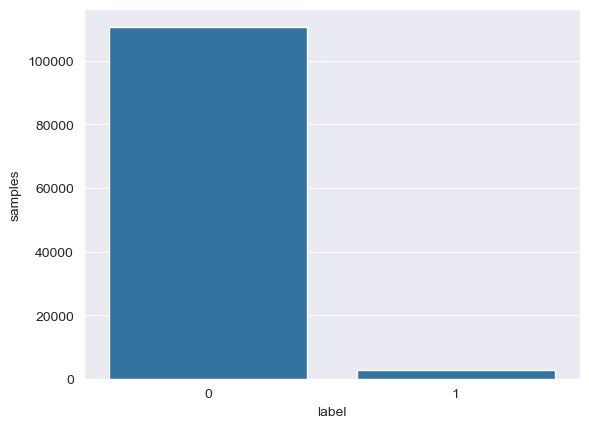

In [7]:
x=train_data_log.label.value_counts()
sns.barplot(x=x.index,y=x)
plt.gca().set_ylabel('samples')



In [8]:
# get only values counts for label 1 because label 0 is the majority class
numbers_samples=train_data_log.label.value_counts()[1] 
print(numbers_samples)

2689


In [9]:
df_safe = train_data_log[train_data_log.label==0].sample(numbers_samples, random_state=2024)
df_suspecious = train_data_log[train_data_log.label==1].sample(numbers_samples, random_state=2024)
train_data_log_balanced = pd.concat([df_safe,df_suspecious],axis=0)
train_data_log_balanced.label.value_counts()

label
0    2689
1    2689
Name: count, dtype: int64

####  Now we have balanced data for both of 2 classes


### First,we will do very basic analysis,that is character level,word level and sentence level analysis.


### Number of characters in logs


Text(0.5, 0.98, 'Characters in logs')

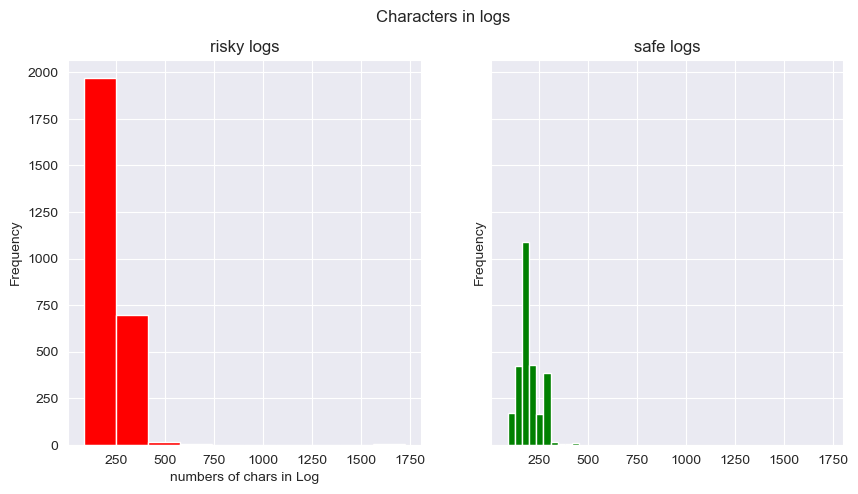

In [10]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
log_len=train_data_log_balanced[train_data_log_balanced['label']==1]['log_line'].str.len()
ax1.hist(log_len,color='red')
# Setting titles for the x-axis and y-axis in the first subplot
ax1.set_xlabel('numbers of chars in Log')
ax1.set_ylabel('Frequency') 
ax1.set_title('risky logs')
log_len=train_data_log_balanced[train_data_log_balanced['label']==0]['log_line'].str.len()
ax2.hist(log_len,color='green')
# Setting titles for the x-axis and y-axis in the first subplot
ax1.set_xlabel('numbers of chars in Log')
ax2.set_ylabel('Frequency') 
ax2.set_title('safe logs')
fig.suptitle('Characters in logs')

100 to 300 characters in a log are the most common among both.

### Number of words in logs


Text(0.5, 0.98, 'Words in a log')

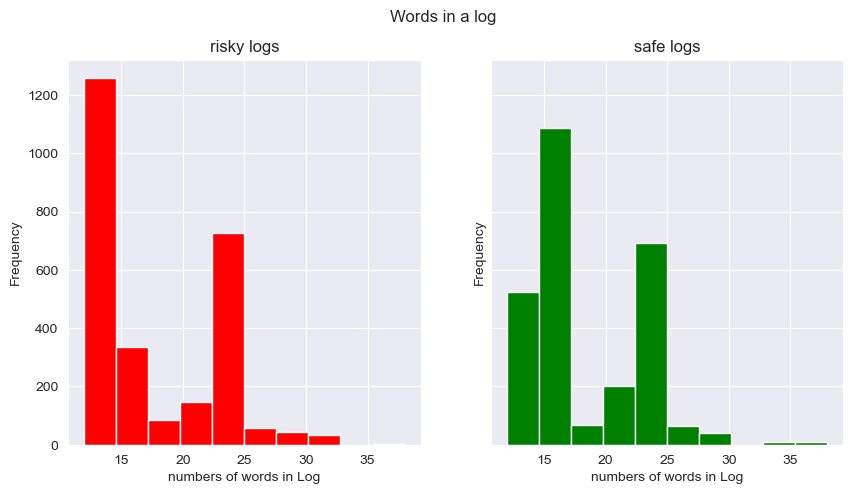

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
log_len=train_data_log_balanced[train_data_log_balanced['label']==1]['log_line'].str.split().map(lambda x: len(x))
ax1.hist(log_len,color='red')
# Setting titles for the x-axis and y-axis in the first subplot
ax1.set_xlabel('numbers of words in Log')
ax1.set_ylabel('Frequency') 
ax1.set_title('risky logs')
tweet_len=train_data_log_balanced[train_data_log_balanced['label']==0]['log_line'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
# Setting titles for the x-axis and y-axis in the first subplot
ax2.set_xlabel('numbers of words in Log')
ax2.set_ylabel('Frequency') 
ax2.set_title('safe logs')
fig.suptitle('Words in a log')

17 to 30 words in a log are the most common among both.

## Analyzing punctuation

In [12]:
# This function takes a label as input and creates a corpus by extracting words from log lines
def create_corpus_for_punctuation(label):
    # Initialize an empty list to store the words in the corpus.
    corpus = []
    # Iterate through log lines that correspond to the given label in the 'train_data_log_balanced' DataFrame.
    for log in train_data_log_balanced[train_data_log_balanced['label'] == label]['log_line'].str.split():
        # Iterate through each word in the log line and add it to the corpus.
        for word in log:
            corpus.append(word)
    return corpus


In [13]:
corpus_safe_for_punctuation=create_corpus_for_punctuation(0)

In [14]:
corpus_safe_for_punctuation

['54.36.148.59',
 '-',
 '-',
 '[06/Jul/2021:00:51:26',
 '-0700]',
 '"GET',
 '/self.logs/error.log.2018-04-03.gz',
 'HTTP/1.1"',
 '200',
 '5971',
 '"-"',
 '"Mozilla/5.0',
 '(compatible#',
 'AhrefsBot/7.0#',
 '+http://ahrefs.com/robot/)"',
 '85.208.98.51',
 '-',
 '-',
 '[31/May/2021:22:52:16',
 '-0700]',
 '"GET',
 '/Datasets%20Description/Network/ssh.html',
 'HTTP/1.1"',
 '301',
 '493',
 '"-"',
 '"Mozilla/5.0',
 '(compatible#',
 'SemrushBot-BM/1.0#',
 '+http://www.semrush.com/bot.html)"',
 '157.55.39.45',
 '-',
 '-',
 '[05/Jun/2021:03:30:46',
 '-0700]',
 '"GET',
 '/self.logs/access.log.2017-02-14.gz',
 'HTTP/1.1"',
 '301',
 '543',
 '"-"',
 '"Mozilla/5.0',
 '(compatible#',
 'bingbot/2.0#',
 '+http://www.bing.com/bingbot.htm)"',
 '49.7.20.120',
 '-',
 '-',
 '[26/Jul/2021:12:35:29',
 '-0700]',
 '"GET',
 '/',
 'HTTP/1.1"',
 '200',
 '12846',
 '"-"',
 '"Sogou',
 'web',
 'spider/4.0(+http://www.sogou.com/docs/help/webmasters.htm#07)"',
 '40.77.167.38',
 '-',
 '-',
 '[13/Jun/2021:04:06:18',
 '-0

<BarContainer object of 2 artists>

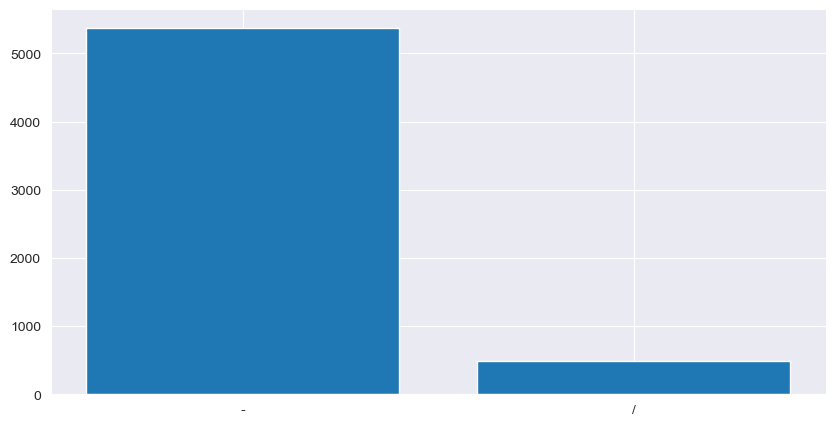

In [15]:
plt.figure(figsize=(10,5))
# Create a dictionary of word and its frequency in the corpus
dic=defaultdict(int)
special = string.punctuation
for word in (corpus_safe_for_punctuation):
    if word in special:
        dic[word]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

## See most common words using spacy

In [16]:
def create_corpus(label):
    # Separate each word in a log and append it to the corpus with default split (space)
    corpus = list(train_data_log_balanced[train_data_log_balanced['label'] == label]['log_line'])
    return corpus

In [17]:
corpus_safe = create_corpus(0)

In [18]:
# !python -m spacy download en_core_web_sm 

In [19]:
nlp=spacy.load('en_core_web_sm')
## This is a simple example of how to use spacy to remove stop words and punctuation and create a new corpus
new_corpus=[]   
for doc in corpus_safe:
    remaining_tokens = []
    # Assuming you are using spaCy for natural language processing
    doc_tokens = nlp(doc)
    for token in doc_tokens:
        if token.is_stop or token.is_punct:
            continue
        remaining_tokens.append(token.text)
        new_corpus.append(remaining_tokens)

In [20]:
print(new_corpus[0])

['54.36.148.59', '06', 'Jul/2021:00:51:26', '-0700', '/self.logs', 'error.log.2018', '04', '03.gz', 'HTTP/1.1', '200', '5971', 'Mozilla/5.0', 'compatible', 'AhrefsBot/7.0', '+', 'http://ahrefs.com/robot/']


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



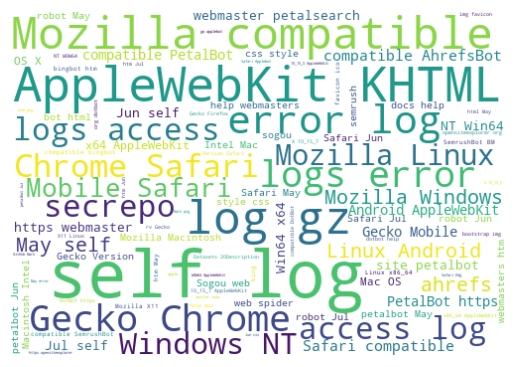

In [21]:
# Create stopword list
stopwords = set(STOPWORDS)

def plot_world_cloud (text):# Create and generate a word cloud image:
    wordcloud = WordCloud(width=500, height=350, stopwords=stopwords, max_words=100, background_color="white").generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
# get all log entries
text = " ".join(" ".join(entry) for entry in new_corpus)
print(text)
plot_world_cloud(text)